In [1]:
import os
import pickle
import config
import dnnlib
import gzip
import json
import numpy as np
from tqdm import tqdm_notebook
import warnings
import matplotlib.pylab as plt
%matplotlib inline
warnings.filterwarnings("ignore")

# Loading data

In [2]:
# Thanks for Microsoft Cognitive Services API (free trial) for labeling of generated images
# https://azure.microsoft.com/en-us/services/cognitive-services/face/

# A pretty simple logic was used for generating images:

# qlatents = np.random.normal(size=(1, 512))
# dlatents = Gs_network.components.mapping.run(qlatents, None, minibatch_size=1, randomize_noise=False, structure='fixed') # untruncated by default, I guess
# images = Gs_network.components.synthesis.run(dlatents, minibatch_size=1, randomize_noise=False, output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True), structure='fixed')

# After that generated image was sent to Micriosft API and response was stored as is

In [3]:
LATENT_TRAINING_DATA = 'https://drive.google.com/uc?id=1xMM3AFq0r014IIhBLiMCjKJJvbhLUQ9t'
    
with dnnlib.util.open_url(LATENT_TRAINING_DATA, cache_dir=config.cache_dir) as f:
    qlatent_data, dlatent_data, labels_data = pickle.load(gzip.GzipFile(fileobj=f))

    
labels_data[0]  # wow. many fields. amaze

{'faceId': 'b6807d9a-0ab5-4595-9037-c69c656c5c38',
 'faceRectangle': {'top': 322, 'left': 223, 'width': 584, 'height': 584},
 'faceLandmarks': {'pupilLeft': {'x': 386.0, 'y': 480.7},
  'pupilRight': {'x': 641.7, 'y': 481.1},
  'noseTip': {'x': 518.0, 'y': 648.1},
  'mouthLeft': {'x': 388.9, 'y': 748.0},
  'mouthRight': {'x': 645.1, 'y': 741.8},
  'eyebrowLeftOuter': {'x': 304.3, 'y': 441.0},
  'eyebrowLeftInner': {'x': 466.8, 'y': 442.9},
  'eyeLeftOuter': {'x': 345.4, 'y': 485.3},
  'eyeLeftTop': {'x': 385.2, 'y': 464.8},
  'eyeLeftBottom': {'x': 386.5, 'y': 497.1},
  'eyeLeftInner': {'x': 424.6, 'y': 487.6},
  'eyebrowRightInner': {'x': 572.8, 'y': 448.0},
  'eyebrowRightOuter': {'x': 738.0, 'y': 445.0},
  'eyeRightInner': {'x': 603.8, 'y': 485.0},
  'eyeRightTop': {'x': 646.0, 'y': 466.2},
  'eyeRightBottom': {'x': 644.9, 'y': 496.9},
  'eyeRightOuter': {'x': 686.7, 'y': 485.3},
  'noseRootLeft': {'x': 475.1, 'y': 493.3},
  'noseRootRight': {'x': 547.5, 'y': 493.9},
  'noseLeftAlarT

In [4]:
# Let's play with age and gender
# you can train your own model now

X_data = dlatent_data.reshape((-1, 18*512))
y_age_data = np.array([x['faceAttributes']['age'] for x in labels_data])
y_gender_data = np.array([x['faceAttributes']['gender'] == 'male' for x in labels_data]) # sry girls :(

assert(len(X_data) == len(y_age_data) == len(y_gender_data))
len(X_data)

20307

# EDA

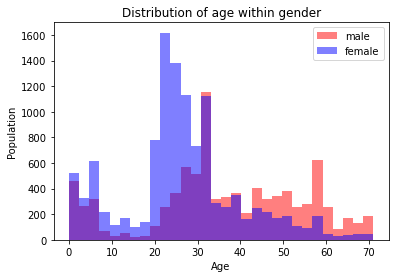

In [5]:
plt.hist(y_age_data[y_gender_data], bins=30, color='red', alpha=0.5, label='male')
plt.hist(y_age_data[~y_gender_data], bins=30, color='blue', alpha=0.5, label='female')
plt.legend()
plt.title('Distribution of age within gender')
plt.xlabel('Age')
plt.ylabel('Population')
plt.show()

# Seems that Dataset / Generator / Detector model may be biased

# Training a linear model for obtaining gender direction in latent space

In [6]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score

In [7]:
%%time
# So let's find the gender direction in the latent space

clf = LogisticRegression(class_weight='balanced').fit(X_data, y_gender_data)
gender_direction = clf.coef_.reshape((18, 512))

# So yep, that's all. We made it.
# But let's do some research first. We'll pick that up later on.

CPU times: user 1min 9s, sys: 177 ms, total: 1min 9s
Wall time: 8.93 s


### Evaluating model performance

In [9]:
# %%time

clf = SGDClassifier('log', class_weight='balanced', n_jobs=-1, early_stopping=True, verbose=3) # SGB model for performance sake
scores = cross_val_score(clf, X_data, y_gender_data, scoring='accuracy', cv=5)
clf.fit(X_data, y_gender_data)

print(scores)
print('Mean: ', np.mean(scores))

# Accuracy ? Meh. But gender distribution is almost balanced ... at least for simplicity sake

-- Epoch 1
Norm: 270.03, NNZs: 9216, Bias: -63.129770, T: 14620, Avg. loss: 60.743993
Total training time: 0.27 seconds.
-- Epoch 2
Norm: 161.22, NNZs: 9216, Bias: -62.754330, T: 29240, Avg. loss: 14.194780
Total training time: 0.67 seconds.
-- Epoch 3
Norm: 114.81, NNZs: 9216, Bias: -59.803623, T: 43860, Avg. loss: 8.510594
Total training time: 1.03 seconds.
-- Epoch 4
Norm: 91.46, NNZs: 9216, Bias: -54.212261, T: 58480, Avg. loss: 6.182993
Total training time: 1.37 seconds.
-- Epoch 5
Norm: 78.16, NNZs: 9216, Bias: -50.924738, T: 73100, Avg. loss: 4.655911
Total training time: 1.73 seconds.
-- Epoch 6
Norm: 66.37, NNZs: 9216, Bias: -47.462292, T: 87720, Avg. loss: 3.864577
Total training time: 2.06 seconds.
-- Epoch 7
Norm: 57.04, NNZs: 9216, Bias: -44.340165, T: 102340, Avg. loss: 3.312129
Total training time: 2.40 seconds.
Convergence after 7 epochs took 2.48 seconds
-- Epoch 1
Norm: 269.66, NNZs: 9216, Bias: -74.832605, T: 14620, Avg. loss: 61.554518
Total training time: 0.27 seco

#### Dependency of gender detection errors on age 

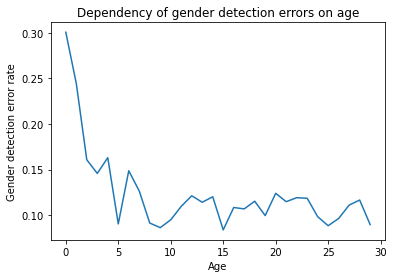

In [10]:
bins, bin_edges = np.histogram(y_age_data, bins=30)
errors,_ = np.histogram(y_age_data[clf.predict(X_data) != y_gender_data], bin_edges)

plt.plot(errors / bins)
plt.title('Dependency of gender detection errors on age')
plt.ylabel('Gender detection error rate')
plt.xlabel('Age')
plt.show()

# Seems that the most diffictul for model is to distinguish babies. For me as well to be honest.
# Or model which we used for creating "ground truth" produces random guesses
# I bet that both are true

#### Dependency of accuracy on training data size

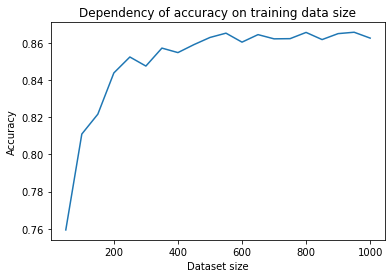

CPU times: user 2min 36s, sys: 3.91 s, total: 2min 40s
Wall time: 31.2 s


In [11]:
%%time

nb_folds = 5
splits = 20
scores = np.zeros((splits, nb_folds))
dataset_size = list()

for fold_id, (train_idx, test_idx) in enumerate(StratifiedKFold(nb_folds, True, 42).split(X_data, y_gender_data)):
    X_train, X_test = X_data[train_idx][:1000], X_data[test_idx]
    y_train, y_test = y_gender_data[train_idx][:1000], y_gender_data[test_idx]
    
    for split_id in range(splits):
        nb_samples = int((len(X_train)/splits) * (split_id+1))
        dataset_size.append(nb_samples)
        clf = SGDClassifier('log', class_weight='balanced').fit(X_train[:nb_samples], y_train[:nb_samples])
        scores[split_id][fold_id] = accuracy_score(y_test, clf.predict(X_test))
        

plt.plot(dataset_size[:splits], scores.mean(axis=1))
plt.title('Dependency of accuracy on training data size')
plt.xlabel('Dataset size')
plt.ylabel('Accuracy')
plt.show()

# Seems that 100 labeled examples is already enough to reach 80% accuracy (for gender).
# That's an interesting insight.

#### Latent layers importance

-- Epoch 1
Norm: 57.64, NNZs: 512, Bias: -9.987129, T: 16245, Avg. loss: 3.539385
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 33.91, NNZs: 512, Bias: -4.685635, T: 32490, Avg. loss: 0.794306
Total training time: 0.04 seconds.
-- Epoch 3
Norm: 25.03, NNZs: 512, Bias: -2.621497, T: 48735, Avg. loss: 0.490147
Total training time: 0.05 seconds.
-- Epoch 4
Norm: 20.01, NNZs: 512, Bias: -1.540115, T: 64980, Avg. loss: 0.371371
Total training time: 0.07 seconds.
-- Epoch 5
Norm: 17.62, NNZs: 512, Bias: -1.690253, T: 81225, Avg. loss: 0.321706
Total training time: 0.09 seconds.
-- Epoch 6
Norm: 16.12, NNZs: 512, Bias: -1.472553, T: 97470, Avg. loss: 0.288250
Total training time: 0.11 seconds.
-- Epoch 7
Norm: 14.97, NNZs: 512, Bias: -1.167447, T: 113715, Avg. loss: 0.274187
Total training time: 0.12 seconds.
-- Epoch 8
Norm: 14.19, NNZs: 512, Bias: -1.361748, T: 129960, Avg. loss: 0.258454
Total training time: 0.14 seconds.
-- Epoch 9
Norm: 13.68, NNZs: 512, Bias: -0.988333, T: 146205,

Norm: 13.38, NNZs: 512, Bias: -1.384218, T: 178706, Avg. loss: 0.240056
Total training time: 0.21 seconds.
-- Epoch 12
Norm: 13.09, NNZs: 512, Bias: -0.977108, T: 194952, Avg. loss: 0.236616
Total training time: 0.23 seconds.
-- Epoch 13
Norm: 12.97, NNZs: 512, Bias: -1.032269, T: 211198, Avg. loss: 0.233532
Total training time: 0.25 seconds.
-- Epoch 14
Norm: 12.76, NNZs: 512, Bias: -1.151604, T: 227444, Avg. loss: 0.231641
Total training time: 0.27 seconds.
-- Epoch 15
Norm: 12.60, NNZs: 512, Bias: -1.034650, T: 243690, Avg. loss: 0.228491
Total training time: 0.28 seconds.
-- Epoch 16
Norm: 12.61, NNZs: 512, Bias: -1.077631, T: 259936, Avg. loss: 0.224797
Total training time: 0.30 seconds.
-- Epoch 17
Norm: 12.51, NNZs: 512, Bias: -1.113803, T: 276182, Avg. loss: 0.224167
Total training time: 0.32 seconds.
-- Epoch 18
Norm: 12.42, NNZs: 512, Bias: -1.094189, T: 292428, Avg. loss: 0.222833
Total training time: 0.34 seconds.
-- Epoch 19
Norm: 12.31, NNZs: 512, Bias: -1.042907, T: 3086

-- Epoch 1
Norm: 56.36, NNZs: 512, Bias: -8.722632, T: 16245, Avg. loss: 3.517802
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 34.32, NNZs: 512, Bias: -3.095731, T: 32490, Avg. loss: 0.792934
Total training time: 0.04 seconds.
-- Epoch 3
Norm: 24.99, NNZs: 512, Bias: -1.682597, T: 48735, Avg. loss: 0.488292
Total training time: 0.05 seconds.
-- Epoch 4
Norm: 20.11, NNZs: 512, Bias: -1.617008, T: 64980, Avg. loss: 0.372554
Total training time: 0.07 seconds.
-- Epoch 5
Norm: 17.59, NNZs: 512, Bias: -1.869897, T: 81225, Avg. loss: 0.321984
Total training time: 0.09 seconds.
-- Epoch 6
Norm: 15.85, NNZs: 512, Bias: -1.667136, T: 97470, Avg. loss: 0.290544
Total training time: 0.11 seconds.
-- Epoch 7
Norm: 15.05, NNZs: 512, Bias: -1.372074, T: 113715, Avg. loss: 0.271720
Total training time: 0.13 seconds.
-- Epoch 8
Norm: 14.41, NNZs: 512, Bias: -1.139289, T: 129960, Avg. loss: 0.261117
Total training time: 0.15 seconds.
-- Epoch 9
Norm: 13.71, NNZs: 512, Bias: -0.901277, T: 146205,

Norm: 12.19, NNZs: 512, Bias: -1.030551, T: 357412, Avg. loss: 0.218859
Total training time: 0.39 seconds.
-- Epoch 23
Norm: 12.11, NNZs: 512, Bias: -0.960583, T: 373658, Avg. loss: 0.216944
Total training time: 0.41 seconds.
-- Epoch 24
Norm: 12.09, NNZs: 512, Bias: -1.123050, T: 389904, Avg. loss: 0.216697
Total training time: 0.43 seconds.
-- Epoch 25
Norm: 12.04, NNZs: 512, Bias: -1.070645, T: 406150, Avg. loss: 0.216993
Total training time: 0.44 seconds.
-- Epoch 26
Norm: 12.03, NNZs: 512, Bias: -0.890094, T: 422396, Avg. loss: 0.215589
Total training time: 0.46 seconds.
-- Epoch 27
Norm: 11.93, NNZs: 512, Bias: -0.926860, T: 438642, Avg. loss: 0.214432
Total training time: 0.48 seconds.
-- Epoch 28
Norm: 11.94, NNZs: 512, Bias: -1.031366, T: 454888, Avg. loss: 0.214267
Total training time: 0.49 seconds.
-- Epoch 29
Norm: 11.92, NNZs: 512, Bias: -1.005722, T: 471134, Avg. loss: 0.213174
Total training time: 0.51 seconds.
-- Epoch 30
Norm: 11.93, NNZs: 512, Bias: -0.932978, T: 4873

Norm: 11.85, NNZs: 512, Bias: -1.218585, T: 487380, Avg. loss: 0.210040
Total training time: 0.55 seconds.
-- Epoch 31
Norm: 11.87, NNZs: 512, Bias: -1.161847, T: 503626, Avg. loss: 0.209198
Total training time: 0.56 seconds.
-- Epoch 32
Norm: 11.86, NNZs: 512, Bias: -1.157054, T: 519872, Avg. loss: 0.209165
Total training time: 0.58 seconds.
-- Epoch 33
Norm: 11.80, NNZs: 512, Bias: -1.200707, T: 536118, Avg. loss: 0.208971
Total training time: 0.60 seconds.
-- Epoch 34
Norm: 11.85, NNZs: 512, Bias: -1.178906, T: 552364, Avg. loss: 0.208242
Total training time: 0.62 seconds.
Convergence after 34 epochs took 0.62 seconds
-- Epoch 1
Norm: 56.04, NNZs: 512, Bias: -7.367030, T: 16245, Avg. loss: 3.408359
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 34.14, NNZs: 512, Bias: -3.244942, T: 32490, Avg. loss: 0.763351
Total training time: 0.04 seconds.
-- Epoch 3
Norm: 24.55, NNZs: 512, Bias: -2.248254, T: 48735, Avg. loss: 0.487836
Total training time: 0.06 seconds.
-- Epoch 4
Norm: 20.

-- Epoch 1
Norm: 55.69, NNZs: 512, Bias: -8.270603, T: 16246, Avg. loss: 3.608848
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 33.66, NNZs: 512, Bias: -2.994235, T: 32492, Avg. loss: 0.771175
Total training time: 0.04 seconds.
-- Epoch 3
Norm: 25.32, NNZs: 512, Bias: -2.148842, T: 48738, Avg. loss: 0.482143
Total training time: 0.06 seconds.
-- Epoch 4
Norm: 20.44, NNZs: 512, Bias: -1.964956, T: 64984, Avg. loss: 0.376652
Total training time: 0.08 seconds.
-- Epoch 5
Norm: 17.95, NNZs: 512, Bias: -1.040053, T: 81230, Avg. loss: 0.320115
Total training time: 0.10 seconds.
-- Epoch 6
Norm: 16.36, NNZs: 512, Bias: -1.149347, T: 97476, Avg. loss: 0.286618
Total training time: 0.12 seconds.
-- Epoch 7
Norm: 15.36, NNZs: 512, Bias: -1.017505, T: 113722, Avg. loss: 0.274833
Total training time: 0.14 seconds.
-- Epoch 8
Norm: 14.65, NNZs: 512, Bias: -1.279787, T: 129968, Avg. loss: 0.261800
Total training time: 0.16 seconds.
-- Epoch 9
Norm: 14.19, NNZs: 512, Bias: -0.996753, T: 146214,

Norm: 12.75, NNZs: 512, Bias: -1.121491, T: 243690, Avg. loss: 0.225575
Total training time: 0.27 seconds.
-- Epoch 16
Norm: 12.53, NNZs: 512, Bias: -1.227947, T: 259936, Avg. loss: 0.223317
Total training time: 0.29 seconds.
-- Epoch 17
Norm: 12.50, NNZs: 512, Bias: -1.159211, T: 276182, Avg. loss: 0.220524
Total training time: 0.30 seconds.
-- Epoch 18
Norm: 12.33, NNZs: 512, Bias: -1.283785, T: 292428, Avg. loss: 0.218243
Total training time: 0.32 seconds.
-- Epoch 19
Norm: 12.32, NNZs: 512, Bias: -1.294026, T: 308674, Avg. loss: 0.217867
Total training time: 0.34 seconds.
-- Epoch 20
Norm: 12.22, NNZs: 512, Bias: -1.158844, T: 324920, Avg. loss: 0.217715
Total training time: 0.36 seconds.
-- Epoch 21
Norm: 12.21, NNZs: 512, Bias: -1.149650, T: 341166, Avg. loss: 0.216415
Total training time: 0.37 seconds.
-- Epoch 22
Norm: 12.14, NNZs: 512, Bias: -1.186787, T: 357412, Avg. loss: 0.215239
Total training time: 0.39 seconds.
-- Epoch 23
Norm: 12.12, NNZs: 512, Bias: -1.072122, T: 3736

-- Epoch 1
Norm: 59.92, NNZs: 512, Bias: -8.553534, T: 16246, Avg. loss: 3.374586
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 34.70, NNZs: 512, Bias: -3.999438, T: 32492, Avg. loss: 0.772647
Total training time: 0.04 seconds.
-- Epoch 3
Norm: 25.48, NNZs: 512, Bias: -2.087842, T: 48738, Avg. loss: 0.490404
Total training time: 0.06 seconds.
-- Epoch 4
Norm: 20.93, NNZs: 512, Bias: -1.847015, T: 64984, Avg. loss: 0.363014
Total training time: 0.08 seconds.
-- Epoch 5
Norm: 18.10, NNZs: 512, Bias: -1.526740, T: 81230, Avg. loss: 0.326410
Total training time: 0.09 seconds.
-- Epoch 6
Norm: 16.51, NNZs: 512, Bias: -1.624804, T: 97476, Avg. loss: 0.287930
Total training time: 0.11 seconds.
-- Epoch 7
Norm: 15.37, NNZs: 512, Bias: -1.347296, T: 113722, Avg. loss: 0.270019
Total training time: 0.13 seconds.
-- Epoch 8
Norm: 14.59, NNZs: 512, Bias: -0.950216, T: 129968, Avg. loss: 0.264052
Total training time: 0.15 seconds.
-- Epoch 9
Norm: 13.94, NNZs: 512, Bias: -1.066961, T: 146214,

Norm: 13.53, NNZs: 512, Bias: -1.319427, T: 162460, Avg. loss: 0.242776
Total training time: 0.18 seconds.
-- Epoch 11
Norm: 13.34, NNZs: 512, Bias: -1.327535, T: 178706, Avg. loss: 0.235887
Total training time: 0.20 seconds.
-- Epoch 12
Norm: 13.07, NNZs: 512, Bias: -1.175316, T: 194952, Avg. loss: 0.233945
Total training time: 0.22 seconds.
-- Epoch 13
Norm: 12.88, NNZs: 512, Bias: -1.179471, T: 211198, Avg. loss: 0.229517
Total training time: 0.23 seconds.
-- Epoch 14
Norm: 12.76, NNZs: 512, Bias: -1.330093, T: 227444, Avg. loss: 0.226245
Total training time: 0.25 seconds.
-- Epoch 15
Norm: 12.63, NNZs: 512, Bias: -1.341967, T: 243690, Avg. loss: 0.223755
Total training time: 0.27 seconds.
-- Epoch 16
Norm: 12.54, NNZs: 512, Bias: -0.987682, T: 259936, Avg. loss: 0.222383
Total training time: 0.29 seconds.
-- Epoch 17
Norm: 12.44, NNZs: 512, Bias: -1.078497, T: 276182, Avg. loss: 0.222915
Total training time: 0.30 seconds.
-- Epoch 18
Norm: 12.35, NNZs: 512, Bias: -1.393967, T: 2924

Norm: 12.22, NNZs: 512, Bias: -1.112397, T: 292410, Avg. loss: 0.223966
Total training time: 0.34 seconds.
-- Epoch 19
Norm: 12.15, NNZs: 512, Bias: -1.049375, T: 308655, Avg. loss: 0.222849
Total training time: 0.36 seconds.
-- Epoch 20
Norm: 12.11, NNZs: 512, Bias: -1.032523, T: 324900, Avg. loss: 0.221580
Total training time: 0.38 seconds.
-- Epoch 21
Norm: 12.00, NNZs: 512, Bias: -1.070550, T: 341145, Avg. loss: 0.221796
Total training time: 0.40 seconds.
-- Epoch 22
Norm: 11.96, NNZs: 512, Bias: -0.993761, T: 357390, Avg. loss: 0.220976
Total training time: 0.41 seconds.
-- Epoch 23
Norm: 11.94, NNZs: 512, Bias: -1.059646, T: 373635, Avg. loss: 0.218556
Total training time: 0.43 seconds.
-- Epoch 24
Norm: 11.93, NNZs: 512, Bias: -1.102084, T: 389880, Avg. loss: 0.219063
Total training time: 0.45 seconds.
-- Epoch 25
Norm: 11.83, NNZs: 512, Bias: -1.060517, T: 406125, Avg. loss: 0.217182
Total training time: 0.47 seconds.
-- Epoch 26
Norm: 11.79, NNZs: 512, Bias: -1.014999, T: 4223

Norm: 11.83, NNZs: 512, Bias: -1.014241, T: 601102, Avg. loss: 0.209056
Total training time: 0.66 seconds.
-- Epoch 38
Norm: 11.84, NNZs: 512, Bias: -1.112899, T: 617348, Avg. loss: 0.208259
Total training time: 0.68 seconds.
-- Epoch 39
Norm: 11.80, NNZs: 512, Bias: -0.993736, T: 633594, Avg. loss: 0.208302
Total training time: 0.69 seconds.
Convergence after 39 epochs took 0.69 seconds
-- Epoch 1
Norm: 57.34, NNZs: 512, Bias: -6.668855, T: 16246, Avg. loss: 3.398117
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 34.15, NNZs: 512, Bias: -4.013858, T: 32492, Avg. loss: 0.788761
Total training time: 0.04 seconds.
-- Epoch 3
Norm: 24.98, NNZs: 512, Bias: -1.883994, T: 48738, Avg. loss: 0.484416
Total training time: 0.05 seconds.
-- Epoch 4
Norm: 20.36, NNZs: 512, Bias: -2.014230, T: 64984, Avg. loss: 0.366154
Total training time: 0.07 seconds.
-- Epoch 5
Norm: 17.98, NNZs: 512, Bias: -1.429220, T: 81230, Avg. loss: 0.319194
Total training time: 0.09 seconds.
-- Epoch 6
Norm: 16.35, 

Norm: 13.80, NNZs: 512, Bias: -1.180669, T: 146205, Avg. loss: 0.254064
Total training time: 0.16 seconds.
-- Epoch 10
Norm: 13.49, NNZs: 512, Bias: -1.201801, T: 162450, Avg. loss: 0.244454
Total training time: 0.18 seconds.
-- Epoch 11
Norm: 13.17, NNZs: 512, Bias: -1.154601, T: 178695, Avg. loss: 0.242088
Total training time: 0.20 seconds.
-- Epoch 12
Norm: 12.99, NNZs: 512, Bias: -1.130210, T: 194940, Avg. loss: 0.234032
Total training time: 0.22 seconds.
-- Epoch 13
Norm: 12.77, NNZs: 512, Bias: -0.808238, T: 211185, Avg. loss: 0.233943
Total training time: 0.24 seconds.
-- Epoch 14
Norm: 12.63, NNZs: 512, Bias: -1.113264, T: 227430, Avg. loss: 0.231492
Total training time: 0.26 seconds.
-- Epoch 15
Norm: 12.54, NNZs: 512, Bias: -1.156410, T: 243675, Avg. loss: 0.229583
Total training time: 0.28 seconds.
-- Epoch 16
Norm: 12.41, NNZs: 512, Bias: -1.103341, T: 259920, Avg. loss: 0.227256
Total training time: 0.29 seconds.
-- Epoch 17
Norm: 12.31, NNZs: 512, Bias: -1.060751, T: 2761

Norm: 13.83, NNZs: 512, Bias: -1.195531, T: 162460, Avg. loss: 0.242745
Total training time: 0.18 seconds.
-- Epoch 11
Norm: 13.63, NNZs: 512, Bias: -1.213419, T: 178706, Avg. loss: 0.238428
Total training time: 0.20 seconds.
-- Epoch 12
Norm: 13.33, NNZs: 512, Bias: -1.036806, T: 194952, Avg. loss: 0.233578
Total training time: 0.21 seconds.
-- Epoch 13
Norm: 13.04, NNZs: 512, Bias: -1.258460, T: 211198, Avg. loss: 0.231609
Total training time: 0.23 seconds.
-- Epoch 14
Norm: 12.88, NNZs: 512, Bias: -1.147032, T: 227444, Avg. loss: 0.227869
Total training time: 0.25 seconds.
-- Epoch 15
Norm: 12.75, NNZs: 512, Bias: -1.095530, T: 243690, Avg. loss: 0.226096
Total training time: 0.27 seconds.
-- Epoch 16
Norm: 12.70, NNZs: 512, Bias: -1.146405, T: 259936, Avg. loss: 0.223274
Total training time: 0.28 seconds.
-- Epoch 17
Norm: 12.59, NNZs: 512, Bias: -1.276573, T: 276182, Avg. loss: 0.221516
Total training time: 0.30 seconds.
-- Epoch 18
Norm: 12.50, NNZs: 512, Bias: -1.074503, T: 2924

Norm: 12.12, NNZs: 512, Bias: -1.002066, T: 324900, Avg. loss: 0.220476
Total training time: 0.36 seconds.
-- Epoch 21
Norm: 12.05, NNZs: 512, Bias: -1.112496, T: 341145, Avg. loss: 0.218576
Total training time: 0.38 seconds.
-- Epoch 22
Norm: 11.93, NNZs: 512, Bias: -1.113055, T: 357390, Avg. loss: 0.218770
Total training time: 0.39 seconds.
-- Epoch 23
Norm: 11.93, NNZs: 512, Bias: -1.135183, T: 373635, Avg. loss: 0.217247
Total training time: 0.41 seconds.
-- Epoch 24
Norm: 11.89, NNZs: 512, Bias: -1.001477, T: 389880, Avg. loss: 0.217092
Total training time: 0.43 seconds.
-- Epoch 25
Norm: 11.82, NNZs: 512, Bias: -1.084244, T: 406125, Avg. loss: 0.215613
Total training time: 0.45 seconds.
-- Epoch 26
Norm: 11.78, NNZs: 512, Bias: -0.994611, T: 422370, Avg. loss: 0.215331
Total training time: 0.47 seconds.
-- Epoch 27
Norm: 11.74, NNZs: 512, Bias: -1.004837, T: 438615, Avg. loss: 0.215288
Total training time: 0.48 seconds.
-- Epoch 28
Norm: 11.81, NNZs: 512, Bias: -1.063336, T: 4548

Norm: 11.89, NNZs: 512, Bias: -0.919389, T: 487380, Avg. loss: 0.213628
Total training time: 0.55 seconds.
-- Epoch 31
Norm: 11.91, NNZs: 512, Bias: -0.957224, T: 503626, Avg. loss: 0.212806
Total training time: 0.57 seconds.
Convergence after 31 epochs took 0.57 seconds
-- Epoch 1
Norm: 58.18, NNZs: 512, Bias: -4.224357, T: 16246, Avg. loss: 3.346935
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 34.27, NNZs: 512, Bias: -4.710172, T: 32492, Avg. loss: 0.757049
Total training time: 0.04 seconds.
-- Epoch 3
Norm: 24.68, NNZs: 512, Bias: -2.452456, T: 48738, Avg. loss: 0.483867
Total training time: 0.06 seconds.
-- Epoch 4
Norm: 20.60, NNZs: 512, Bias: -1.388113, T: 64984, Avg. loss: 0.379405
Total training time: 0.08 seconds.
-- Epoch 5
Norm: 17.98, NNZs: 512, Bias: -1.973118, T: 81230, Avg. loss: 0.322245
Total training time: 0.10 seconds.
-- Epoch 6
Norm: 16.40, NNZs: 512, Bias: -1.656993, T: 97476, Avg. loss: 0.287217
Total training time: 0.12 seconds.
-- Epoch 7
Norm: 15.23, NN

Norm: 56.52, NNZs: 512, Bias: -5.099432, T: 16245, Avg. loss: 3.498506
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 33.34, NNZs: 512, Bias: -2.822423, T: 32490, Avg. loss: 0.790962
Total training time: 0.04 seconds.
-- Epoch 3
Norm: 24.32, NNZs: 512, Bias: -2.605117, T: 48735, Avg. loss: 0.483072
Total training time: 0.06 seconds.
-- Epoch 4
Norm: 20.15, NNZs: 512, Bias: -2.206508, T: 64980, Avg. loss: 0.372633
Total training time: 0.08 seconds.
-- Epoch 5
Norm: 17.14, NNZs: 512, Bias: -1.615792, T: 81225, Avg. loss: 0.323093
Total training time: 0.10 seconds.
-- Epoch 6
Norm: 15.84, NNZs: 512, Bias: -1.188003, T: 97470, Avg. loss: 0.289137
Total training time: 0.11 seconds.
-- Epoch 7
Norm: 14.84, NNZs: 512, Bias: -1.345337, T: 113715, Avg. loss: 0.274661
Total training time: 0.13 seconds.
-- Epoch 8
Norm: 14.20, NNZs: 512, Bias: -1.333511, T: 129960, Avg. loss: 0.259663
Total training time: 0.15 seconds.
-- Epoch 9
Norm: 13.78, NNZs: 512, Bias: -1.307186, T: 146205, Avg. loss:

Norm: 12.92, NNZs: 512, Bias: -0.993855, T: 211198, Avg. loss: 0.232125
Total training time: 0.23 seconds.
-- Epoch 14
Norm: 12.84, NNZs: 512, Bias: -1.095267, T: 227444, Avg. loss: 0.231362
Total training time: 0.25 seconds.
-- Epoch 15
Norm: 12.73, NNZs: 512, Bias: -0.814650, T: 243690, Avg. loss: 0.226452
Total training time: 0.27 seconds.
-- Epoch 16
Norm: 12.58, NNZs: 512, Bias: -1.161970, T: 259936, Avg. loss: 0.225000
Total training time: 0.29 seconds.
-- Epoch 17
Norm: 12.53, NNZs: 512, Bias: -1.112694, T: 276182, Avg. loss: 0.224281
Total training time: 0.30 seconds.
-- Epoch 18
Norm: 12.42, NNZs: 512, Bias: -1.103705, T: 292428, Avg. loss: 0.222405
Total training time: 0.32 seconds.
-- Epoch 19
Norm: 12.28, NNZs: 512, Bias: -0.974115, T: 308674, Avg. loss: 0.221137
Total training time: 0.34 seconds.
-- Epoch 20
Norm: 12.29, NNZs: 512, Bias: -0.868002, T: 324920, Avg. loss: 0.219400
Total training time: 0.36 seconds.
-- Epoch 21
Norm: 12.27, NNZs: 512, Bias: -1.069274, T: 3411

Norm: 12.17, NNZs: 512, Bias: -1.205678, T: 324920, Avg. loss: 0.217746
Total training time: 0.36 seconds.
-- Epoch 21
Norm: 12.23, NNZs: 512, Bias: -1.140344, T: 341166, Avg. loss: 0.215656
Total training time: 0.38 seconds.
-- Epoch 22
Norm: 12.12, NNZs: 512, Bias: -1.016054, T: 357412, Avg. loss: 0.215353
Total training time: 0.39 seconds.
-- Epoch 23
Norm: 12.07, NNZs: 512, Bias: -1.229140, T: 373658, Avg. loss: 0.214796
Total training time: 0.41 seconds.
-- Epoch 24
Norm: 12.04, NNZs: 512, Bias: -1.132025, T: 389904, Avg. loss: 0.214532
Total training time: 0.43 seconds.
-- Epoch 25
Norm: 12.06, NNZs: 512, Bias: -1.167390, T: 406150, Avg. loss: 0.212400
Total training time: 0.45 seconds.
-- Epoch 26
Norm: 11.96, NNZs: 512, Bias: -1.211666, T: 422396, Avg. loss: 0.213217
Total training time: 0.46 seconds.
-- Epoch 27
Norm: 11.94, NNZs: 512, Bias: -1.191911, T: 438642, Avg. loss: 0.211554
Total training time: 0.48 seconds.
-- Epoch 28
Norm: 11.91, NNZs: 512, Bias: -1.200744, T: 4548

Norm: 33.95, NNZs: 512, Bias: -4.868768, T: 32492, Avg. loss: 0.773078
Total training time: 0.04 seconds.
-- Epoch 3
Norm: 24.80, NNZs: 512, Bias: -3.273528, T: 48738, Avg. loss: 0.490361
Total training time: 0.05 seconds.
-- Epoch 4
Norm: 20.76, NNZs: 512, Bias: -1.736063, T: 64984, Avg. loss: 0.372078
Total training time: 0.07 seconds.
-- Epoch 5
Norm: 18.00, NNZs: 512, Bias: -1.333808, T: 81230, Avg. loss: 0.324069
Total training time: 0.10 seconds.
-- Epoch 6
Norm: 16.51, NNZs: 512, Bias: -1.695349, T: 97476, Avg. loss: 0.293173
Total training time: 0.12 seconds.
-- Epoch 7
Norm: 15.56, NNZs: 512, Bias: -1.088105, T: 113722, Avg. loss: 0.271450
Total training time: 0.14 seconds.
-- Epoch 8
Norm: 14.65, NNZs: 512, Bias: -0.887579, T: 129968, Avg. loss: 0.262881
Total training time: 0.15 seconds.
-- Epoch 9
Norm: 14.05, NNZs: 512, Bias: -1.153700, T: 146214, Avg. loss: 0.254108
Total training time: 0.17 seconds.
-- Epoch 10
Norm: 13.71, NNZs: 512, Bias: -1.237648, T: 162460, Avg. los

Norm: 12.12, NNZs: 512, Bias: -1.202900, T: 357412, Avg. loss: 0.214868
Total training time: 0.39 seconds.
-- Epoch 23
Norm: 12.10, NNZs: 512, Bias: -1.273581, T: 373658, Avg. loss: 0.213810
Total training time: 0.41 seconds.
-- Epoch 24
Norm: 12.04, NNZs: 512, Bias: -1.241398, T: 389904, Avg. loss: 0.214796
Total training time: 0.43 seconds.
-- Epoch 25
Norm: 12.00, NNZs: 512, Bias: -1.253527, T: 406150, Avg. loss: 0.211857
Total training time: 0.45 seconds.
-- Epoch 26
Norm: 12.00, NNZs: 512, Bias: -1.223711, T: 422396, Avg. loss: 0.212573
Total training time: 0.47 seconds.
-- Epoch 27
Norm: 11.95, NNZs: 512, Bias: -1.238649, T: 438642, Avg. loss: 0.211734
Total training time: 0.48 seconds.
-- Epoch 28
Norm: 11.94, NNZs: 512, Bias: -1.174646, T: 454888, Avg. loss: 0.210435
Total training time: 0.50 seconds.
-- Epoch 29
Norm: 11.88, NNZs: 512, Bias: -1.122128, T: 471134, Avg. loss: 0.210573
Total training time: 0.52 seconds.
-- Epoch 30
Norm: 11.89, NNZs: 512, Bias: -1.105756, T: 4873

Norm: 11.91, NNZs: 512, Bias: -0.996898, T: 389880, Avg. loss: 0.219174
Total training time: 0.43 seconds.
-- Epoch 25
Norm: 11.90, NNZs: 512, Bias: -0.990393, T: 406125, Avg. loss: 0.217938
Total training time: 0.45 seconds.
-- Epoch 26
Norm: 11.85, NNZs: 512, Bias: -0.979180, T: 422370, Avg. loss: 0.216056
Total training time: 0.47 seconds.
-- Epoch 27
Norm: 11.82, NNZs: 512, Bias: -0.933261, T: 438615, Avg. loss: 0.216529
Total training time: 0.48 seconds.
-- Epoch 28
Norm: 11.80, NNZs: 512, Bias: -0.982118, T: 454860, Avg. loss: 0.215389
Total training time: 0.50 seconds.
-- Epoch 29
Norm: 11.71, NNZs: 512, Bias: -0.991885, T: 471105, Avg. loss: 0.215858
Total training time: 0.52 seconds.
-- Epoch 30
Norm: 11.75, NNZs: 512, Bias: -1.038693, T: 487350, Avg. loss: 0.213840
Total training time: 0.54 seconds.
-- Epoch 31
Norm: 11.71, NNZs: 512, Bias: -0.976263, T: 503595, Avg. loss: 0.214232
Total training time: 0.55 seconds.
-- Epoch 32
Norm: 11.71, NNZs: 512, Bias: -0.998658, T: 5198

Norm: 12.34, NNZs: 512, Bias: -1.122188, T: 324920, Avg. loss: 0.217946
Total training time: 0.36 seconds.
-- Epoch 21
Norm: 12.30, NNZs: 512, Bias: -0.970092, T: 341166, Avg. loss: 0.217799
Total training time: 0.38 seconds.
-- Epoch 22
Norm: 12.15, NNZs: 512, Bias: -0.945674, T: 357412, Avg. loss: 0.217427
Total training time: 0.40 seconds.
-- Epoch 23
Norm: 12.15, NNZs: 512, Bias: -1.089479, T: 373658, Avg. loss: 0.215306
Total training time: 0.42 seconds.
-- Epoch 24
Norm: 12.10, NNZs: 512, Bias: -1.058662, T: 389904, Avg. loss: 0.214133
Total training time: 0.43 seconds.
-- Epoch 25
Norm: 12.08, NNZs: 512, Bias: -1.087088, T: 406150, Avg. loss: 0.214194
Total training time: 0.45 seconds.
-- Epoch 26
Norm: 12.08, NNZs: 512, Bias: -1.001102, T: 422396, Avg. loss: 0.212895
Total training time: 0.47 seconds.
-- Epoch 27
Norm: 12.05, NNZs: 512, Bias: -1.042573, T: 438642, Avg. loss: 0.213066
Total training time: 0.49 seconds.
-- Epoch 28
Norm: 12.02, NNZs: 512, Bias: -1.015523, T: 4548

Norm: 12.54, NNZs: 512, Bias: -0.912777, T: 243675, Avg. loss: 0.228395
Total training time: 0.27 seconds.
-- Epoch 16
Norm: 12.39, NNZs: 512, Bias: -1.025242, T: 259920, Avg. loss: 0.224894
Total training time: 0.29 seconds.
-- Epoch 17
Norm: 12.21, NNZs: 512, Bias: -0.935279, T: 276165, Avg. loss: 0.225407
Total training time: 0.31 seconds.
-- Epoch 18
Norm: 12.13, NNZs: 512, Bias: -1.048332, T: 292410, Avg. loss: 0.224356
Total training time: 0.32 seconds.
-- Epoch 19
Norm: 12.12, NNZs: 512, Bias: -0.916757, T: 308655, Avg. loss: 0.221953
Total training time: 0.34 seconds.
-- Epoch 20
Norm: 11.99, NNZs: 512, Bias: -1.003486, T: 324900, Avg. loss: 0.220871
Total training time: 0.36 seconds.
-- Epoch 21
Norm: 12.03, NNZs: 512, Bias: -1.227873, T: 341145, Avg. loss: 0.219061
Total training time: 0.37 seconds.
-- Epoch 22
Norm: 11.98, NNZs: 512, Bias: -1.087680, T: 357390, Avg. loss: 0.218835
Total training time: 0.39 seconds.
-- Epoch 23
Norm: 11.96, NNZs: 512, Bias: -1.091055, T: 3736

Norm: 12.59, NNZs: 512, Bias: -1.102951, T: 243690, Avg. loss: 0.228142
Total training time: 0.27 seconds.
-- Epoch 16
Norm: 12.42, NNZs: 512, Bias: -1.072313, T: 259936, Avg. loss: 0.224451
Total training time: 0.28 seconds.
-- Epoch 17
Norm: 12.38, NNZs: 512, Bias: -1.000152, T: 276182, Avg. loss: 0.225516
Total training time: 0.30 seconds.
-- Epoch 18
Norm: 12.37, NNZs: 512, Bias: -0.842174, T: 292428, Avg. loss: 0.222717
Total training time: 0.32 seconds.
-- Epoch 19
Norm: 12.23, NNZs: 512, Bias: -1.017067, T: 308674, Avg. loss: 0.221124
Total training time: 0.34 seconds.
-- Epoch 20
Norm: 12.19, NNZs: 512, Bias: -0.909616, T: 324920, Avg. loss: 0.220325
Total training time: 0.36 seconds.
-- Epoch 21
Norm: 12.10, NNZs: 512, Bias: -0.916028, T: 341166, Avg. loss: 0.219482
Total training time: 0.37 seconds.
-- Epoch 22
Norm: 12.11, NNZs: 512, Bias: -1.022714, T: 357412, Avg. loss: 0.218126
Total training time: 0.39 seconds.
-- Epoch 23
Norm: 12.10, NNZs: 512, Bias: -1.111038, T: 3736

Norm: 12.48, NNZs: 512, Bias: -1.011938, T: 276182, Avg. loss: 0.220570
Total training time: 0.31 seconds.
-- Epoch 18
Norm: 12.35, NNZs: 512, Bias: -1.196688, T: 292428, Avg. loss: 0.218122
Total training time: 0.33 seconds.
-- Epoch 19
Norm: 12.27, NNZs: 512, Bias: -1.134820, T: 308674, Avg. loss: 0.218266
Total training time: 0.34 seconds.
-- Epoch 20
Norm: 12.26, NNZs: 512, Bias: -1.111417, T: 324920, Avg. loss: 0.216371
Total training time: 0.36 seconds.
-- Epoch 21
Norm: 12.13, NNZs: 512, Bias: -1.207889, T: 341166, Avg. loss: 0.216722
Total training time: 0.38 seconds.
-- Epoch 22
Norm: 12.09, NNZs: 512, Bias: -1.217501, T: 357412, Avg. loss: 0.215500
Total training time: 0.40 seconds.
-- Epoch 23
Norm: 12.08, NNZs: 512, Bias: -1.185315, T: 373658, Avg. loss: 0.213754
Total training time: 0.42 seconds.
-- Epoch 24
Norm: 12.06, NNZs: 512, Bias: -1.129941, T: 389904, Avg. loss: 0.213383
Total training time: 0.43 seconds.
-- Epoch 25
Norm: 11.98, NNZs: 512, Bias: -1.168149, T: 4061

Norm: 15.80, NNZs: 512, Bias: -1.168347, T: 97470, Avg. loss: 0.290467
Total training time: 0.11 seconds.
-- Epoch 7
Norm: 14.62, NNZs: 512, Bias: -1.418883, T: 113715, Avg. loss: 0.276551
Total training time: 0.13 seconds.
-- Epoch 8
Norm: 14.36, NNZs: 512, Bias: -1.257350, T: 129960, Avg. loss: 0.261720
Total training time: 0.15 seconds.
-- Epoch 9
Norm: 13.85, NNZs: 512, Bias: -1.239403, T: 146205, Avg. loss: 0.252897
Total training time: 0.17 seconds.
-- Epoch 10
Norm: 13.35, NNZs: 512, Bias: -1.221132, T: 162450, Avg. loss: 0.248000
Total training time: 0.18 seconds.
-- Epoch 11
Norm: 13.07, NNZs: 512, Bias: -1.152301, T: 178695, Avg. loss: 0.242083
Total training time: 0.20 seconds.
-- Epoch 12
Norm: 12.94, NNZs: 512, Bias: -1.025054, T: 194940, Avg. loss: 0.237537
Total training time: 0.22 seconds.
-- Epoch 13
Norm: 12.73, NNZs: 512, Bias: -1.199434, T: 211185, Avg. loss: 0.235065
Total training time: 0.24 seconds.
-- Epoch 14
Norm: 12.66, NNZs: 512, Bias: -0.975551, T: 227430, 

Norm: 15.38, NNZs: 512, Bias: -1.292103, T: 113722, Avg. loss: 0.273463
Total training time: 0.13 seconds.
-- Epoch 8
Norm: 14.61, NNZs: 512, Bias: -1.408572, T: 129968, Avg. loss: 0.259690
Total training time: 0.14 seconds.
-- Epoch 9
Norm: 14.04, NNZs: 512, Bias: -1.030065, T: 146214, Avg. loss: 0.249805
Total training time: 0.16 seconds.
-- Epoch 10
Norm: 13.74, NNZs: 512, Bias: -1.222214, T: 162460, Avg. loss: 0.244415
Total training time: 0.18 seconds.
-- Epoch 11
Norm: 13.39, NNZs: 512, Bias: -1.125339, T: 178706, Avg. loss: 0.237462
Total training time: 0.20 seconds.
-- Epoch 12
Norm: 13.21, NNZs: 512, Bias: -0.927092, T: 194952, Avg. loss: 0.232458
Total training time: 0.22 seconds.
-- Epoch 13
Norm: 13.04, NNZs: 512, Bias: -1.175355, T: 211198, Avg. loss: 0.230878
Total training time: 0.23 seconds.
-- Epoch 14
Norm: 12.89, NNZs: 512, Bias: -1.270019, T: 227444, Avg. loss: 0.228436
Total training time: 0.25 seconds.
-- Epoch 15
Norm: 12.72, NNZs: 512, Bias: -1.113064, T: 243690

Norm: 13.00, NNZs: 512, Bias: -1.213981, T: 194940, Avg. loss: 0.236990
Total training time: 0.22 seconds.
-- Epoch 13
Norm: 12.72, NNZs: 512, Bias: -1.042964, T: 211185, Avg. loss: 0.234066
Total training time: 0.23 seconds.
-- Epoch 14
Norm: 12.60, NNZs: 512, Bias: -0.936911, T: 227430, Avg. loss: 0.230945
Total training time: 0.25 seconds.
-- Epoch 15
Norm: 12.49, NNZs: 512, Bias: -1.126917, T: 243675, Avg. loss: 0.227948
Total training time: 0.27 seconds.
-- Epoch 16
Norm: 12.47, NNZs: 512, Bias: -0.925802, T: 259920, Avg. loss: 0.225481
Total training time: 0.29 seconds.
-- Epoch 17
Norm: 12.26, NNZs: 512, Bias: -1.081779, T: 276165, Avg. loss: 0.224126
Total training time: 0.31 seconds.
-- Epoch 18
Norm: 12.22, NNZs: 512, Bias: -0.999419, T: 292410, Avg. loss: 0.222890
Total training time: 0.32 seconds.
-- Epoch 19
Norm: 12.11, NNZs: 512, Bias: -0.937100, T: 308655, Avg. loss: 0.221528
Total training time: 0.34 seconds.
-- Epoch 20
Norm: 12.05, NNZs: 512, Bias: -1.031773, T: 3249

Norm: 12.27, NNZs: 512, Bias: -1.068017, T: 341166, Avg. loss: 0.219067
Total training time: 0.37 seconds.
-- Epoch 22
Norm: 12.19, NNZs: 512, Bias: -1.242168, T: 357412, Avg. loss: 0.217968
Total training time: 0.39 seconds.
-- Epoch 23
Norm: 12.12, NNZs: 512, Bias: -0.935907, T: 373658, Avg. loss: 0.217697
Total training time: 0.41 seconds.
-- Epoch 24
Norm: 12.12, NNZs: 512, Bias: -0.935314, T: 389904, Avg. loss: 0.215569
Total training time: 0.43 seconds.
-- Epoch 25
Norm: 12.01, NNZs: 512, Bias: -1.129271, T: 406150, Avg. loss: 0.216794
Total training time: 0.44 seconds.
-- Epoch 26
Norm: 12.00, NNZs: 512, Bias: -0.883659, T: 422396, Avg. loss: 0.214943
Total training time: 0.46 seconds.
-- Epoch 27
Norm: 12.00, NNZs: 512, Bias: -0.935987, T: 438642, Avg. loss: 0.214877
Total training time: 0.48 seconds.
-- Epoch 28
Norm: 11.97, NNZs: 512, Bias: -0.960324, T: 454888, Avg. loss: 0.213372
Total training time: 0.50 seconds.
-- Epoch 29
Norm: 11.91, NNZs: 512, Bias: -1.106763, T: 4711

Norm: 12.29, NNZs: 512, Bias: -1.339892, T: 308674, Avg. loss: 0.218092
Total training time: 0.34 seconds.
-- Epoch 20
Norm: 12.32, NNZs: 512, Bias: -1.151424, T: 324920, Avg. loss: 0.217154
Total training time: 0.36 seconds.
-- Epoch 21
Norm: 12.24, NNZs: 512, Bias: -1.109065, T: 341166, Avg. loss: 0.215276
Total training time: 0.38 seconds.
-- Epoch 22
Norm: 12.22, NNZs: 512, Bias: -1.288603, T: 357412, Avg. loss: 0.215386
Total training time: 0.39 seconds.
-- Epoch 23
Norm: 12.14, NNZs: 512, Bias: -1.277233, T: 373658, Avg. loss: 0.212683
Total training time: 0.41 seconds.
-- Epoch 24
Norm: 12.12, NNZs: 512, Bias: -1.278950, T: 389904, Avg. loss: 0.213771
Total training time: 0.43 seconds.
-- Epoch 25
Norm: 12.05, NNZs: 512, Bias: -1.242261, T: 406150, Avg. loss: 0.213174
Total training time: 0.45 seconds.
-- Epoch 26
Norm: 12.01, NNZs: 512, Bias: -1.315494, T: 422396, Avg. loss: 0.211897
Total training time: 0.46 seconds.
-- Epoch 27
Norm: 11.97, NNZs: 512, Bias: -1.208070, T: 4386

Norm: 12.71, NNZs: 512, Bias: -0.905780, T: 227444, Avg. loss: 0.229205
Total training time: 0.25 seconds.
-- Epoch 15
Norm: 12.62, NNZs: 512, Bias: -1.161023, T: 243690, Avg. loss: 0.228718
Total training time: 0.27 seconds.
-- Epoch 16
Norm: 12.49, NNZs: 512, Bias: -1.196747, T: 259936, Avg. loss: 0.224614
Total training time: 0.29 seconds.
-- Epoch 17
Norm: 12.42, NNZs: 512, Bias: -0.887964, T: 276182, Avg. loss: 0.223698
Total training time: 0.31 seconds.
-- Epoch 18
Norm: 12.41, NNZs: 512, Bias: -1.003459, T: 292428, Avg. loss: 0.222570
Total training time: 0.32 seconds.
-- Epoch 19
Norm: 12.24, NNZs: 512, Bias: -1.052432, T: 308674, Avg. loss: 0.221556
Total training time: 0.34 seconds.
-- Epoch 20
Norm: 12.21, NNZs: 512, Bias: -1.044967, T: 324920, Avg. loss: 0.220237
Total training time: 0.36 seconds.
-- Epoch 21
Norm: 12.22, NNZs: 512, Bias: -1.057673, T: 341166, Avg. loss: 0.218526
Total training time: 0.38 seconds.
-- Epoch 22
Norm: 12.13, NNZs: 512, Bias: -0.821312, T: 3574

Norm: 12.83, NNZs: 512, Bias: -1.274789, T: 227444, Avg. loss: 0.227569
Total training time: 0.30 seconds.
-- Epoch 15
Norm: 12.56, NNZs: 512, Bias: -1.077690, T: 243690, Avg. loss: 0.223768
Total training time: 0.32 seconds.
-- Epoch 16
Norm: 12.50, NNZs: 512, Bias: -1.252970, T: 259936, Avg. loss: 0.223476
Total training time: 0.34 seconds.
-- Epoch 17
Norm: 12.53, NNZs: 512, Bias: -1.168342, T: 276182, Avg. loss: 0.221177
Total training time: 0.36 seconds.
-- Epoch 18
Norm: 12.40, NNZs: 512, Bias: -1.373271, T: 292428, Avg. loss: 0.219961
Total training time: 0.38 seconds.
-- Epoch 19
Norm: 12.34, NNZs: 512, Bias: -1.275164, T: 308674, Avg. loss: 0.217330
Total training time: 0.39 seconds.
-- Epoch 20
Norm: 12.29, NNZs: 512, Bias: -1.365251, T: 324920, Avg. loss: 0.217059
Total training time: 0.41 seconds.
-- Epoch 21
Norm: 12.17, NNZs: 512, Bias: -1.147937, T: 341166, Avg. loss: 0.218329
Total training time: 0.43 seconds.
-- Epoch 22
Norm: 12.14, NNZs: 512, Bias: -1.229338, T: 3574

Norm: 11.77, NNZs: 512, Bias: -1.100463, T: 471105, Avg. loss: 0.215021
Total training time: 0.53 seconds.
-- Epoch 30
Norm: 11.80, NNZs: 512, Bias: -1.005416, T: 487350, Avg. loss: 0.215192
Total training time: 0.54 seconds.
-- Epoch 31
Norm: 11.71, NNZs: 512, Bias: -0.934533, T: 503595, Avg. loss: 0.214873
Total training time: 0.56 seconds.
-- Epoch 32
Norm: 11.68, NNZs: 512, Bias: -1.075485, T: 519840, Avg. loss: 0.213038
Total training time: 0.58 seconds.
-- Epoch 33
Norm: 11.68, NNZs: 512, Bias: -0.984839, T: 536085, Avg. loss: 0.212944
Total training time: 0.60 seconds.
-- Epoch 34
Norm: 11.67, NNZs: 512, Bias: -1.035915, T: 552330, Avg. loss: 0.213105
Total training time: 0.61 seconds.
-- Epoch 35
Norm: 11.67, NNZs: 512, Bias: -0.907326, T: 568575, Avg. loss: 0.212858
Total training time: 0.63 seconds.
-- Epoch 36
Norm: 11.62, NNZs: 512, Bias: -0.959129, T: 584820, Avg. loss: 0.212469
Total training time: 0.65 seconds.
-- Epoch 37
Norm: 11.62, NNZs: 512, Bias: -1.053949, T: 6010

Norm: 12.12, NNZs: 512, Bias: -1.067153, T: 406150, Avg. loss: 0.214308
Total training time: 0.44 seconds.
-- Epoch 26
Norm: 12.10, NNZs: 512, Bias: -1.105744, T: 422396, Avg. loss: 0.212622
Total training time: 0.46 seconds.
-- Epoch 27
Norm: 12.07, NNZs: 512, Bias: -0.963170, T: 438642, Avg. loss: 0.212667
Total training time: 0.48 seconds.
-- Epoch 28
Norm: 12.02, NNZs: 512, Bias: -1.034319, T: 454888, Avg. loss: 0.212140
Total training time: 0.50 seconds.
-- Epoch 29
Norm: 11.94, NNZs: 512, Bias: -0.982861, T: 471134, Avg. loss: 0.212292
Total training time: 0.51 seconds.
-- Epoch 30
Norm: 11.94, NNZs: 512, Bias: -0.889866, T: 487380, Avg. loss: 0.211258
Total training time: 0.53 seconds.
-- Epoch 31
Norm: 11.89, NNZs: 512, Bias: -1.107561, T: 503626, Avg. loss: 0.212137
Total training time: 0.55 seconds.
Convergence after 31 epochs took 0.55 seconds
-- Epoch 1
Norm: 57.75, NNZs: 512, Bias: -7.943134, T: 16246, Avg. loss: 3.373785
Total training time: 0.02 seconds.
-- Epoch 2
Norm:

Norm: 33.69, NNZs: 512, Bias: -4.264217, T: 32490, Avg. loss: 0.815436
Total training time: 0.04 seconds.
-- Epoch 3
Norm: 24.93, NNZs: 512, Bias: -3.053612, T: 48735, Avg. loss: 0.482589
Total training time: 0.05 seconds.
-- Epoch 4
Norm: 20.43, NNZs: 512, Bias: -2.183737, T: 64980, Avg. loss: 0.378621
Total training time: 0.07 seconds.
-- Epoch 5
Norm: 17.89, NNZs: 512, Bias: -1.304816, T: 81225, Avg. loss: 0.314287
Total training time: 0.09 seconds.
-- Epoch 6
Norm: 16.09, NNZs: 512, Bias: -1.399024, T: 97470, Avg. loss: 0.298066
Total training time: 0.11 seconds.
-- Epoch 7
Norm: 15.15, NNZs: 512, Bias: -0.806714, T: 113715, Avg. loss: 0.274098
Total training time: 0.12 seconds.
-- Epoch 8
Norm: 14.40, NNZs: 512, Bias: -1.081850, T: 129960, Avg. loss: 0.259784
Total training time: 0.14 seconds.
-- Epoch 9
Norm: 13.93, NNZs: 512, Bias: -1.229509, T: 146205, Avg. loss: 0.255243
Total training time: 0.16 seconds.
-- Epoch 10
Norm: 13.54, NNZs: 512, Bias: -1.142979, T: 162450, Avg. los

Norm: 56.20, NNZs: 512, Bias: -6.764292, T: 16246, Avg. loss: 3.410421
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 32.68, NNZs: 512, Bias: -3.810345, T: 32492, Avg. loss: 0.774016
Total training time: 0.04 seconds.
-- Epoch 3
Norm: 24.53, NNZs: 512, Bias: -2.929445, T: 48738, Avg. loss: 0.476453
Total training time: 0.05 seconds.
-- Epoch 4
Norm: 20.36, NNZs: 512, Bias: -1.599624, T: 64984, Avg. loss: 0.371944
Total training time: 0.07 seconds.
-- Epoch 5
Norm: 17.67, NNZs: 512, Bias: -1.758323, T: 81230, Avg. loss: 0.321021
Total training time: 0.09 seconds.
-- Epoch 6
Norm: 16.37, NNZs: 512, Bias: -1.250586, T: 97476, Avg. loss: 0.286470
Total training time: 0.11 seconds.
-- Epoch 7
Norm: 15.33, NNZs: 512, Bias: -1.093159, T: 113722, Avg. loss: 0.271150
Total training time: 0.12 seconds.
-- Epoch 8
Norm: 14.58, NNZs: 512, Bias: -1.251446, T: 129968, Avg. loss: 0.260705
Total training time: 0.14 seconds.
-- Epoch 9
Norm: 14.04, NNZs: 512, Bias: -1.136599, T: 146214, Avg. loss:

Norm: 17.38, NNZs: 512, Bias: -1.892787, T: 81225, Avg. loss: 0.325013
Total training time: 0.09 seconds.
-- Epoch 6
Norm: 15.89, NNZs: 512, Bias: -1.671442, T: 97470, Avg. loss: 0.291125
Total training time: 0.11 seconds.
-- Epoch 7
Norm: 14.84, NNZs: 512, Bias: -1.180100, T: 113715, Avg. loss: 0.271977
Total training time: 0.13 seconds.
-- Epoch 8
Norm: 14.27, NNZs: 512, Bias: -1.236954, T: 129960, Avg. loss: 0.258360
Total training time: 0.14 seconds.
-- Epoch 9
Norm: 13.88, NNZs: 512, Bias: -1.011049, T: 146205, Avg. loss: 0.249809
Total training time: 0.16 seconds.
-- Epoch 10
Norm: 13.42, NNZs: 512, Bias: -1.241781, T: 162450, Avg. loss: 0.245134
Total training time: 0.18 seconds.
-- Epoch 11
Norm: 13.16, NNZs: 512, Bias: -1.200408, T: 178695, Avg. loss: 0.240840
Total training time: 0.20 seconds.
-- Epoch 12
Norm: 13.06, NNZs: 512, Bias: -1.169857, T: 194940, Avg. loss: 0.235177
Total training time: 0.21 seconds.
-- Epoch 13
Norm: 12.74, NNZs: 512, Bias: -1.168326, T: 211185, Av

Norm: 12.02, NNZs: 512, Bias: -0.992090, T: 373658, Avg. loss: 0.217760
Total training time: 0.43 seconds.
-- Epoch 24
Norm: 11.98, NNZs: 512, Bias: -0.995990, T: 389904, Avg. loss: 0.217080
Total training time: 0.45 seconds.
-- Epoch 25
Norm: 11.98, NNZs: 512, Bias: -1.047739, T: 406150, Avg. loss: 0.214125
Total training time: 0.47 seconds.
-- Epoch 26
Norm: 11.94, NNZs: 512, Bias: -1.097862, T: 422396, Avg. loss: 0.214534
Total training time: 0.49 seconds.
-- Epoch 27
Norm: 11.91, NNZs: 512, Bias: -0.938466, T: 438642, Avg. loss: 0.215012
Total training time: 0.51 seconds.
-- Epoch 28
Norm: 11.99, NNZs: 512, Bias: -0.951977, T: 454888, Avg. loss: 0.213587
Total training time: 0.52 seconds.
-- Epoch 29
Norm: 11.90, NNZs: 512, Bias: -1.067633, T: 471134, Avg. loss: 0.214416
Total training time: 0.54 seconds.
-- Epoch 30
Norm: 11.92, NNZs: 512, Bias: -1.138102, T: 487380, Avg. loss: 0.213414
Total training time: 0.56 seconds.
Convergence after 30 epochs took 0.56 seconds
-- Epoch 1
Nor

Norm: 11.85, NNZs: 512, Bias: -1.234051, T: 552364, Avg. loss: 0.207914
Total training time: 0.63 seconds.
-- Epoch 35
Norm: 11.83, NNZs: 512, Bias: -1.141446, T: 568610, Avg. loss: 0.208310
Total training time: 0.65 seconds.
-- Epoch 36
Norm: 11.82, NNZs: 512, Bias: -1.198027, T: 584856, Avg. loss: 0.207835
Total training time: 0.67 seconds.
Convergence after 36 epochs took 0.67 seconds
-- Epoch 1
Norm: 57.66, NNZs: 512, Bias: -6.777264, T: 16245, Avg. loss: 3.569343
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 34.30, NNZs: 512, Bias: -2.574197, T: 32490, Avg. loss: 0.780170
Total training time: 0.04 seconds.
-- Epoch 3
Norm: 24.89, NNZs: 512, Bias: -2.198064, T: 48735, Avg. loss: 0.492158
Total training time: 0.05 seconds.
-- Epoch 4
Norm: 19.99, NNZs: 512, Bias: -1.960661, T: 64980, Avg. loss: 0.377460
Total training time: 0.07 seconds.
-- Epoch 5
Norm: 17.56, NNZs: 512, Bias: -1.735769, T: 81225, Avg. loss: 0.319834
Total training time: 0.09 seconds.
-- Epoch 6
Norm: 16.24, 

-- Epoch 8
Norm: 14.63, NNZs: 512, Bias: -1.430547, T: 129968, Avg. loss: 0.261433
Total training time: 0.14 seconds.
-- Epoch 9
Norm: 14.08, NNZs: 512, Bias: -1.181804, T: 146214, Avg. loss: 0.250984
Total training time: 0.16 seconds.
-- Epoch 10
Norm: 13.80, NNZs: 512, Bias: -1.211677, T: 162460, Avg. loss: 0.244538
Total training time: 0.18 seconds.
-- Epoch 11
Norm: 13.47, NNZs: 512, Bias: -1.213336, T: 178706, Avg. loss: 0.240510
Total training time: 0.20 seconds.
-- Epoch 12
Norm: 13.14, NNZs: 512, Bias: -1.149307, T: 194952, Avg. loss: 0.235025
Total training time: 0.22 seconds.
-- Epoch 13
Norm: 12.90, NNZs: 512, Bias: -1.136574, T: 211198, Avg. loss: 0.232512
Total training time: 0.23 seconds.
-- Epoch 14
Norm: 12.84, NNZs: 512, Bias: -1.091073, T: 227444, Avg. loss: 0.228863
Total training time: 0.25 seconds.
-- Epoch 15
Norm: 12.76, NNZs: 512, Bias: -1.025711, T: 243690, Avg. loss: 0.228363
Total training time: 0.27 seconds.
-- Epoch 16
Norm: 12.69, NNZs: 512, Bias: -1.09239

Norm: 14.21, NNZs: 512, Bias: -1.244521, T: 146214, Avg. loss: 0.245091
Total training time: 0.16 seconds.
-- Epoch 10
Norm: 13.76, NNZs: 512, Bias: -1.275689, T: 162460, Avg. loss: 0.241930
Total training time: 0.18 seconds.
-- Epoch 11
Norm: 13.36, NNZs: 512, Bias: -1.374069, T: 178706, Avg. loss: 0.237129
Total training time: 0.20 seconds.
-- Epoch 12
Norm: 13.20, NNZs: 512, Bias: -1.477712, T: 194952, Avg. loss: 0.232087
Total training time: 0.21 seconds.
-- Epoch 13
Norm: 13.02, NNZs: 512, Bias: -1.081903, T: 211198, Avg. loss: 0.228917
Total training time: 0.23 seconds.
-- Epoch 14
Norm: 12.74, NNZs: 512, Bias: -1.157871, T: 227444, Avg. loss: 0.227129
Total training time: 0.25 seconds.
-- Epoch 15
Norm: 12.67, NNZs: 512, Bias: -1.201426, T: 243690, Avg. loss: 0.225370
Total training time: 0.26 seconds.
-- Epoch 16
Norm: 12.60, NNZs: 512, Bias: -1.280584, T: 259936, Avg. loss: 0.222643
Total training time: 0.28 seconds.
-- Epoch 17
Norm: 12.48, NNZs: 512, Bias: -1.353945, T: 2761

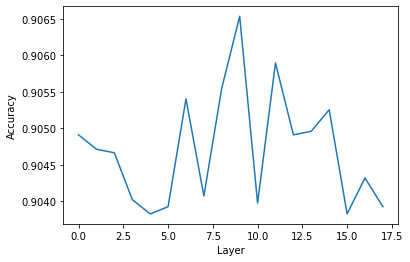

In [13]:
# Let's try to find out which latent layer is most useful for predicting gender

scores = list()
for layer in tqdm_notebook(range(18)):
    clf = SGDClassifier('log', class_weight='balanced', n_jobs=-1, verbose=3)
    scores.append(cross_val_score(clf, X_data.reshape((-1, 18, 512))[:,layer], y_gender_data, scoring='accuracy', cv=5).mean())
    
plt.plot(np.arange(0,18), scores)
plt.xlabel('Layer')
plt.ylabel('Accuracy')
plt.show()

# Huh? Seems that every latent layer contains some information about gender.
# I didn't expect that to be honest.

# Visualization of gender transformation

In [16]:
%%time
# Do you remember gender_direction ? 
# Anyway let's train it one more time

clf = LogisticRegression(class_weight='balanced')
clf.fit(X_data.reshape((-1, 18*512)), y_gender_data)
gender_dircetion = clf.coef_.reshape((18, 512))

CPU times: user 1min 6s, sys: 140 ms, total: 1min 6s
Wall time: 8.53 s


In [10]:
import PIL.Image
import dnnlib.tflib as tflib
import dnnlib
import config
from encoder.generator_model import Generator

URL_FFHQ = 'https://drive.google.com/uc?id=1MEGjdvVpUsu1jB4zrXZN7Y4kBBOzizDQ'

tflib.init_tf()
with dnnlib.util.open_url(URL_FFHQ, cache_dir=config.cache_dir) as f:
    generator_network, discriminator_network, Gs_network = pickle.load(f)

generator = Generator(Gs_network, batch_size=1, randomize_noise=False)

def generate_image(latent_vector):
    latent_vector = latent_vector.reshape((1, 18, 512))
    generator.set_dlatents(latent_vector)
    img_array = generator.generate_images()[0]
    img = PIL.Image.fromarray(img_array, 'RGB')
    return img.resize((256, 256))

def move_and_show(latent_vector, direction, coeffs):
    fig,ax = plt.subplots(1, len(coeffs), figsize=(15, 10), dpi=80)
    for i, coeff in enumerate(coeffs):
        new_latent_vector = latent_vector.copy()
        new_latent_vector[:8] = (latent_vector + coeff*direction)[:8]
        ax[i].imshow(generate_image(new_latent_vector))
        ax[i].set_title('Coeff: %0.1f' % coeff)
    [x.axis('off') for x in ax]
    plt.show()

AttributeError: module 'config' has no attribute 'cache_dir'

In [ ]:
# For generating these face untruncated sampling was used

for i in range(10):
    move_and_show(X_data.reshape((-1, 18, 512))[i], gender_dircetion, [-5, -1.5, 0, 1.5, 5])

In [ ]:
donald_trump = np.load('ffhq_dataset/latent_representations/donald_trump_01.npy')
move_and_show(donald_trump, gender_dircetion, [-5, -1.5, 0, 1.5, 5])

In [ ]:
#
# Better approach for learning better representations is coming...some regularization magic is happening
#
# donald_trump = np.load('dark/deep/fantasy')
# move_and_show(donald_trump, gender_dircetion, [-5, -1.5, 0, 1.5, 5])

# - here is some images -

# Try to use some non-linear model

In [ ]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Embedding, Flatten, Activation
from keras.optimizers import SGD

In [ ]:
model = Sequential()
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

model.fit(X_data.reshape((-1, 18*512)), y_gender_data, validation_split=0.2, epochs=5)
model = Model(model.input, model.layers[-2].output)

# works bit better, but in general accuracy is quite similar to the linear model

In [ ]:
# some dark magic is happening here

embedding_model = Sequential()
embedding_model.add(Embedding(10, 18*512, input_length=1)) # it's actually just a variable
embedding_model.add(Flatten())

nonliner_gender_model = Model(embedding_model.input, model(embedding_model.output))
nonliner_gender_model.layers[-1].trainable = False # fix non-linear model and train only embeddings
nonliner_gender_model.compile('sgd', 'mse')

nonliner_gender_model.layers[1].set_weights([X_data[:10].reshape((-1, 18*512))])
y_data_real = nonliner_gender_model.predict(np.arange(10))
y_data_real

In [ ]:
# and here

nonliner_gender_model.fit(np.arange(10), np.full((10, 1), 20), verbose=0, epochs=500)
nonliner_gender_model.predict(np.arange(10))

In [ ]:
for v in embedding_model.layers[0].get_weights()[0]:
    plt.imshow(generate_image(v))
    plt.show()

In [ ]:
# reset latents and try it over but now in another direction 
nonliner_gender_model.layers[1].set_weights([X_data[:10].reshape((-1, 18*512))])

nonliner_gender_model.fit(np.arange(10), np.full((10, 1), -20), verbose=0, epochs=500)

for v in embedding_model.layers[0].get_weights()[0]:
    plt.imshow(generate_image(v))
    plt.show()

In [ ]:
# Did you expect that it's gonna work ? :)

# In general:
# 1) Instead of linear model we trained a non-linear model (two layers neural network) for predicting age
# 2) For a given latent vector we want to find a direction in non-linear space to become more male\female
# 3) Direction ? Sounds like we can use gradient descent...
# 4) So that's actually what we do, step by step we optimize latent vector to become more male\female